In [109]:
from openseespy.opensees import *
import opsvis as opsv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

In [110]:
wipe()
model('basic','-ndm',2, '-ndf', 3)

In [111]:
# Dimension of frame: Units in kips, ft
width = 360.0
height = 144.0
# Create nodes
node(1, 0.0, 0.0, 0.0)
node(2, width, 0.0, 0.0)
node(3, 0.0, height, 0.0)
node(4, width, height, 0.0)
# Fix at base
fix(1, 1, 1, 1)
fix(2, 1, 1, 1)

In [112]:
# MATERIAL DEFINITION
# # core concrete (confined) => uniaxialMaterial('Concrete01', matTag, fpc, epsc0, fpcu, epsU)
uniaxialMaterial('Concrete01', 1, -6.0, -0.004, -5.0, -0.014)
# # cover concrete (unconfined) => uniaxialMaterial('Concrete01', matTag, fpc, epsc0, fpcu, epsU)
uniaxialMaterial('Concrete01', 2, -5.0, -0.002, 0.0, -0.006)
# # Reinforcing steel => uniaxialMaterial('Steel01', matTag, Fy, E0, b)
    # b => Strain hardening ratio
uniaxialMaterial('Steel01', 3, 60.0, 30000.0, 0.01) 

In [113]:
# Define cross-section for columns
colWidth = 15
colDepth = 24
c = 1.5
As = 0.60  # area of no. 7 bars
# Centroid location
y1 = colDepth / 2.0
z1 = colWidth / 2.0

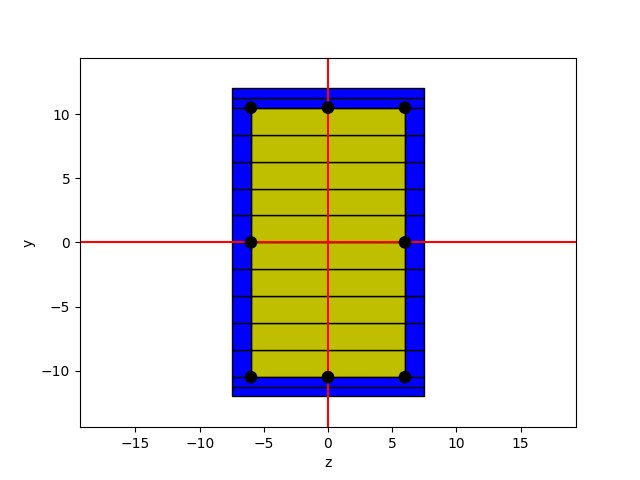

In [114]:
# Define fiber section => section('Fiber', secTag, '-GJ', GJ)
## patch('rect', matTag, numSubdivY, numSubdivZ, *crdsI, *crdsJ)
## layer('straight', matTag, numFiber, areaFiber, *start, *end)
fib_sec_1 = [['section','Fiber', 1, '-GJ', 1.0e6],
            ['patch', 'rect', 1, 10, 1,  c-y1, c-z1,   y1-c, z1-c], #core
            ['patch', 'rect', 2, 2, 1, y1-c, -z1, y1, z1], # top
            ['patch', 'rect', 2, 2, 1, -y1, -z1, c-y1, z1], # bottom
            ['patch', 'rect', 2, 10, 1, c-y1, -z1, y1-c, c-z1], # left
            ['patch', 'rect', 2, 10, 1, c-y1, z1-c, y1-c, z1], # right
            ['layer', 'straight', 3, 3, As, y1-c, c-z1, y1-c, z1-c], # Top
            ['layer', 'straight', 3, 3, As, c-y1, c-z1, c-y1, z1-c], # Bottom
            ['layer', 'straight', 3, 2, As, 0, c-z1, 0, z1-c] # Middle
             ]

opsv.fib_sec_list_to_cmds(fib_sec_1) # defines fiber through 'opsvis'
opsv.plot_fiber_section(fib_sec_1)
plt.axis('equal')
plt.axhline(0,color='r')  # Z-axis
plt.axvline(0, color='r')  # Y-axis
plt.xlim(-z1 * 1.2, z1 * 1.2)
plt.ylim(-y1 * 1.2, y1 * 1.2)
plt.show()

In [115]:
# Define column elements
geomTransf('PDelta', 1)   # says 'Align my local y-axis with vector <0,1,0> in global space  

# Distributed Plasticity => It allows yielding at any predefined integration points (IPs) along the length of the elements
    # Gauss Lobatto integration => beamIntegration('Lobatto', tag, secTag, N = number of IPs)
    # Newton Cotes integration  => beamIntegration('NewtonCotes', tag, secTag, N = number of IPs) : Equal spacing of IPs
# Plastic Hinge Integration => Only allows yielding to the regions of the element of specified length while remainder of the element stays linear elastic
    # Midpoint Hinge Integraton => beamIntegration('HingeMidpoint', tag, secI, lpI, secJ, lpJ, secE)
    
beamIntegration('Lobatto', 1, 1, 8)
# beamIntegration('HingeMidpoint', 1, 1, 20., 1, 20., 2)
# Create columns => element('forceBeamColumn', eleTag, *eleNodes, transfTag, integrationTag)
element('forceBeamColumn', 1, *[1, 3], 1, 1)
element('forceBeamColumn', 2, *[2, 4], 1, 1)

In [116]:
geomTransf('Linear', 2)
# element('elasticBeamColumn', eleTag, iNode, jNode, A, E, I, transfTag)
element('elasticBeamColumn', 3, *[3, 4], 360.0, 4030.0, 8640.0, 2)

<Axes: >

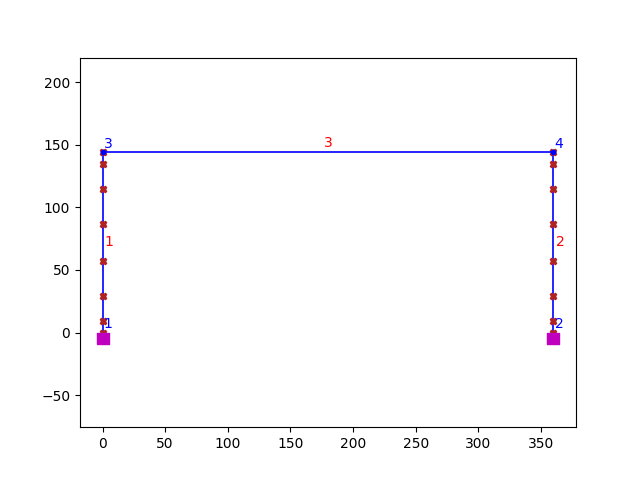

In [117]:
opsv.plot_model()

In [118]:
# DEFINE GRAVITY LOADS
P = 180.0 # 10% of axial capacity of column

timeSeries('Linear', 1) # timeSeries('Linear', 1)
pattern('Plain', 1, 1)
load(3, 0.0, -P, 0.0)
load(4, 0.0, -P, 0.0)

In [119]:
# ANALYSIS SETUP
# Create the system of equation, a sparse solver with partial pivoting
system('BandGeneral')
# Create the constraint handler, the transformation method
constraints('Transformation')
# Create the DOF numberer, the reverse Cuthill-McKee algorithm
numberer('RCM')
# Create the convergence test, the norm of the residual with a tolerance of 1e-12 and a max number of iterations of 10
test('NormDispIncr', 1.0e-12, 10, 3)
# Create the solution algorithm, a Newton-Raphson algorithm
algorithm('Newton')
# Create the integration scheme, the LoadControl scheme using steps of 0.1
integrator('LoadControl', 0.1)
# Create the analysis object
analysis('Static')

In [120]:
# PERFORM THE ANALYSIS
analyze(10) # requires 10 steps to reach the load level

0

In [121]:
u3 = nodeDisp(3, 2)
u4 = nodeDisp(4, 2)
print(f"The displacement of node 3 is {u3:.6f} in.")
print(f"The displacement of node 4 is {u4:.6f} in.")

The displacement of node 3 is -0.018374 in.
The displacement of node 4 is -0.018374 in.


1959.3291927174955

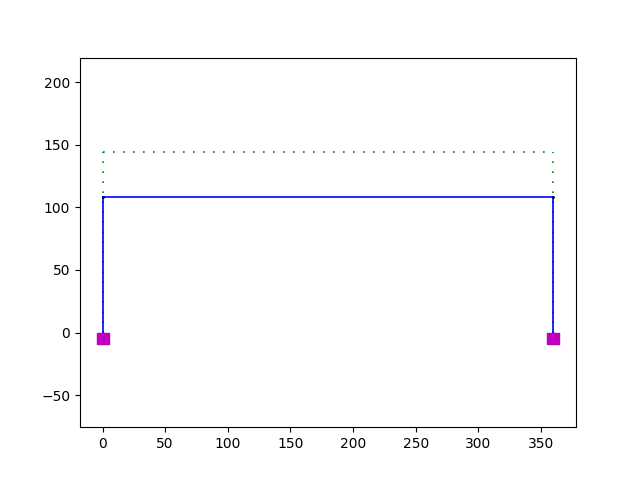

In [122]:
opsv.plot_defo()

### Seismic Analysis

In [123]:
import RecordReader

In [124]:
# Set the gravity loads to be constant & reset the time in the domain
loadConst('-time', 0.0)

In [125]:
# PERFORM INITIAL GRAVITY ANALYSIS
g = 386.4
m = P/g # mass to be assigned at each roof nodes i.e. nodes 3 and 4

In [126]:
# Assign translational mass at each roof nodes
mass(3, *[m, m, 0.0])
mass(4, *[m, m, 0.0])

In [127]:
dt, nPts = RecordReader.ReadRecord('elCentro.at2', 'elCentro.dat')

In [ ]:
# Time Series for acceleration time history
# timeSeries('Path', tag, '-dt', dt=0.0, '-values', *values, '-time', *time, '-filePath', filePath='', '-fileTime', fileTime='', '-factor', factor=1.0, '-startTime', startTime=0.0, '-useLast', '-prependZero')
timeSeries('Path', 2, '-dt', dt, '-filePath', 'elCentro.dat', '-factor', g)

In [129]:
# pattern('UniformExcitation', patternTag, dir, '-disp', dispSeriesTag, '-vel', velSeriesTag, '-accel', accelSeriesTag, '-vel0', vel0, '-fact', fact)
pattern('UniformExcitation', 2, 1, '-accel', 2)

In [130]:
# Set the Rayleigh Damping factor for nodes and elements
# rayleigh(alphaM, betaK, betaKinit, betaKcomm)
rayleigh(0.0, 0.0, 0.0, 0.000625)

In [131]:
# Delete the old analysis and component objects
wipeAnalysis()

In [132]:
# Analysis setup
system('BandGeneral')
constraints('Plain')
test('NormDispIncr', 1.0e-12, 10)
algorithm('Newton')
numberer('RCM')
# integrator('Newmark', gamma, beta, '-form', form)
integrator('Newmark', 0.5, 0.25)
analysis('Transient')

In [133]:
# Perform eigenvalue analysis before transient analysis
numEigen = 2
eigenValues = eigen(numEigen)   # gives the value of w^2
print(f"Eigenvalues at the start of transient analysis: \n {eigenValues}")
periods = [2 * np.pi / np.sqrt(eigenValue) for eigenValue in eigenValues]
print(f"Periods at the start of transient analysis: \n {periods} secs")

Eigenvalues at the start of transient analysis: 
 [266.9852736740754, 17504.535824611965]
Periods at the start of transient analysis: 
 [0.38453530079497406, 0.04749026236766851] secs


In [134]:
# Set some variables
tFinal = dt*nPts   # Total time
tCurrent = getTime()
ok = 0

# Initiate variables to record data
time = [tCurrent]
u3 = [0.0]
a3 = [0.0]

In [135]:
# Perform the transient analysis 
while ok == 0 and tCurrent < tFinal:
    ok = analyze(1, 0.001)  # 0.01 is dt which must be specified for transient analysis
    
    if ok != 0:
        print("Regular Newton algorithm failed. Switching to Modified Newton with initial stiffness for this step.")
        test('NormDispIncr', 1.0e-12,  1000, 0)
        algorithm('ModifiedNewton', '-initial')
        ok = analyze(1, 0.001)
        if ok == 0:
            print("That worked. Switching back to regular Newton algorithm.")
        test('NormDispIncr', 1.0e-12, 10)
        algorithm('Newton')

    tCurrent = getTime()
    
    time.append(tCurrent)
    u3.append(nodeDisp(3,1))
    a3.append(nodeAccel(3,1))

In [136]:
# Perform eigenvalue analysis after transient analysis
numEigen = 2
eigenValues = eigen(numEigen)   # gives the value of w^2
print(f"Eigenvalues after transient analysis: \n {eigenValues}")
periods = [2 * np.pi / np.sqrt(eigenValue) for eigenValue in eigenValues]
print(f"Periods after of transient analysis: \n {periods} secs")

Eigenvalues after transient analysis: 
 [143.2891146175446, 14821.429795968432]
Periods after of transient analysis: 
 [0.5248960067103615, 0.05161011392415608] secs


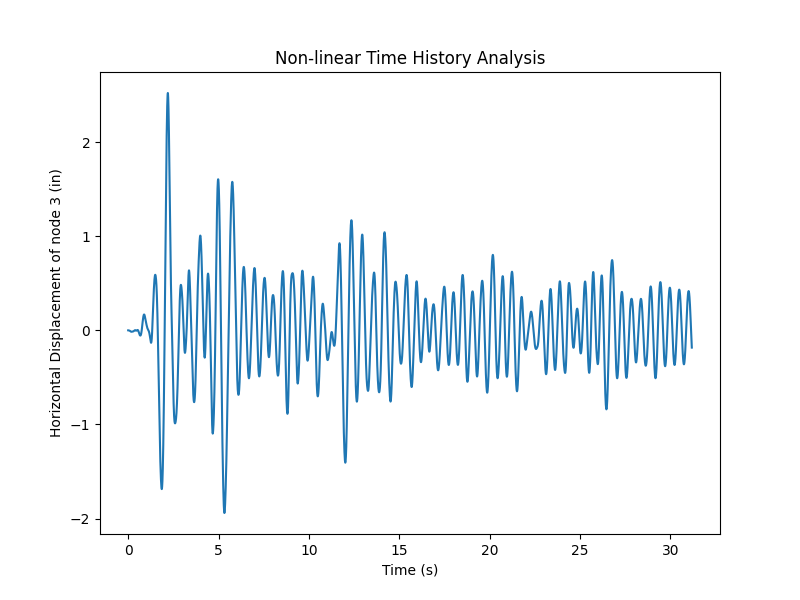

In [137]:
plt.figure(figsize=(8,6))
plt.plot(time, u3)
plt.ylabel('Horizontal Displacement of node 3 (in)')
plt.xlabel('Time (s)')
plt.title('Non-linear Time History Analysis')
plt.show()

### Plotting seismic actions and demands in the same plot


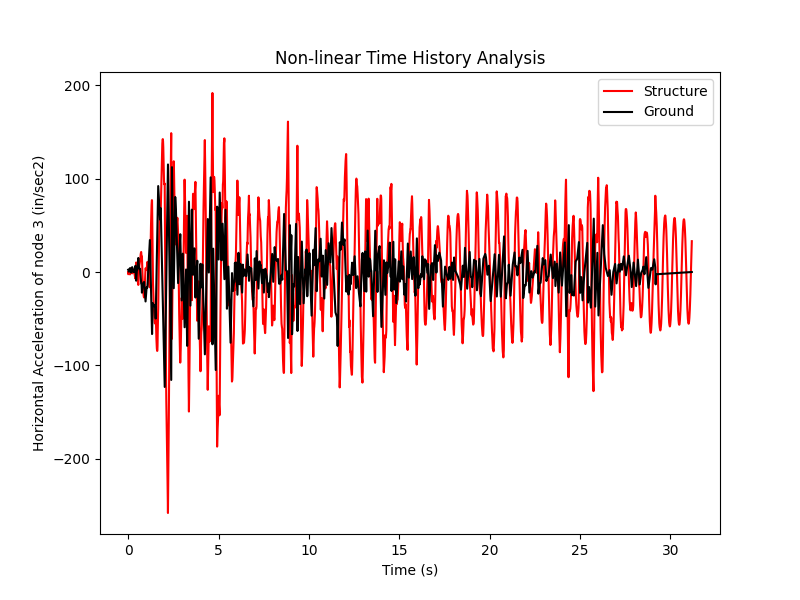

In [152]:
gm_acc = []
with open('elCentro.dat', 'r') as file:
    for line in file:
        # Split line by any whitespace, convert to float
        values = [float(val) for val in line.strip().split()]
        gm_acc.extend(values)  # Add to the list
        
gm_time = np.linspace(0, tFinal, nPts)
gm_acc = list(np.array(gm_acc) * g)

plt.figure(figsize=(8,6))
plt.plot(time, a3, color='r', label='Structure')
plt.plot(gm_time, gm_acc, color='k', label = 'Ground')
plt.ylabel('Horizontal Acceleration of node 3 (in/sec2)')
plt.xlabel('Time (s)')
plt.title('Non-linear Time History Analysis')
plt.legend()
plt.show()